# **Personal League of Legends Data Analysis Tool**

League of Legends (LoL) stands as one of the most popular and competitive online multiplayer games globally, with millions of players engaging in strategic battles to claim victory on the virtual battlefield. In this digital arena, every move, every choice of champion, and every tactical decision can sway the balance between triumph and defeat. In an effort to unravel the intricate dynamics of success in League of Legends, we employ a data-driven approach to analyze the performance of individual players and teams. Through the lens of statistical models, we delve into various facets of gameplay, from champion choices to individual player metrics and economic factors. This tool aims to explore and test hypotheses that seek to uncover patterns and correlations within the data, providing insights into the critical factors that contribute to victory in the competitive landscape of League of Legends. In this context, we outline several hypotheses related to champion performance, individual player metrics, team composition, economic factors, and damage contribution, seeking to validate or challenge assumptions about the key determinants of success in the League of Legends realm.

**Hypothesis on Champion Performance:**

- H0 (Null Hypothesis): The choice of champion does not significantly impact the probability of winning a match.
- H1 (Alternative Hypothesis): Certain champions contribute to a higher probability of winning matches compared to others.

**Hypothesis on Individual Player Performance Metrics:**

- H0: Individual performance metrics (kills, deaths, assists) do not significantly influence the likelihood of winning a match.
- H1: Higher numbers of kills and assists and lower deaths are associated with a higher probability of winning.

**Hypothesis on Economic Factors:**

- H0: Economic factors (gold earned) do not significantly impact the probability of winning a match.
- H1: Teams with higher gold earnings are more likely to win matches.

**Hypothesis on Damage Contribution:**

- H0: The total damage dealt to champions does not affect the likelihood of winning a match.
- H1: Higher total damage dealt to champions is associated with a higher probability of winning.

**Hypothesis on Relative Performance Against Enemy ADC:**

- H0 (Null Hypothesis): There are no significant differences in performance metrics between the player's ADC and the enemy ADC.
- H1 (Alternative Hypothesis): Statistically significant differences exist in performance metrics, indicating that the player's ADC either outperforms or underperforms the enemy ADC in critical aspects such as KDA ratio, total damage dealt to champions, gold earned, assists, deaths, kills, total minions killed, and effective vision score.


**Importing the necessary libraries for our analysis**

In [85]:
import requests
import pandas as pd
import time
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

from scipy.stats import pearsonr, spearmanr

# **Understanding the Dataset and Preprocessing**

This script is designed to retrieve League of Legends match data from the Riot Games API, specifically using the endpoints related to matches. The goal is to collect last 100 match's information (which is the limit of API) for a given player identified by their PUUID (Player Universally Unique Identifier).

**1-**
This code verifies the Riot Games API functionality by fetching summoner information for a given summoner ID in the Turkish server, and displays key details if the API request is successful.

In [86]:
api_key = '#####-######-####-####-####-##########' #Replace with your API key
region = 'TR1'  # Replace with your desired region code
summoner_id = 'fB6t8zjn4YqhV7yuee47EfAOG26q9sPdS-hNkf0SDN2O1q8'  # Replace with the summoner's ID you want to look up

def get_summoner_info(summoner_id, api_key, region):
    url = f'https://{region}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}'
    headers = {'X-Riot-Token': api_key}

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        summoner_info = response.json()
        return summoner_info
    elif response.status_code == 404:
        print("Summoner not found.")
        return None
    elif response.status_code == 403:
        print("Error 403: Forbidden. Check your API key and permissions.")
        return None
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None


summoner_info = get_summoner_info(summoner_id, api_key, region)

if summoner_info:
    print(f"Summoner Name: {summoner_info['name']}")
    print(f"Summoner Level: {summoner_info['summonerLevel']}")
    print(f"Summoner ID: {summoner_info['id']}")
    print(f"Profile Icon ID: {summoner_info['profileIconId']}")



Summoner Name: asstrid
Summoner Level: 211
Summoner ID: fB6t8zjn4YqhV7yuee47EfAOG26q9sPdS-hNkf0SDN2O1q8
Profile Icon ID: 5875


**2-** This code fetches match IDs for a specified player's PUUID from the Riot Games API, retrieves detailed match data for the specified number of matches, and creates a Pandas DataFrame for further analysis, while incorporating rate limiting to adhere to the API constraints.

In [87]:
your_puuid = 'N63LBVS1SKSWshst8NbVMhbSa249-LsJ-XbsmPX_PWLyAoKPm2XtImS1_U0PK59SrBR7FARbdQS6lw' # Change it with your puuid
number_of_Matches = 100 # You can change the number of matches to be considered for analysis

url = f'https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/{your_puuid}/ids?start=0&count={number_of_Matches}'
headers = {'X-Riot-Token': api_key}

response = requests.get(url, headers=headers)
match_ids = response.json()
print(match_ids)

# Define an empty list to store match data
all_match_data = []

for lolMatch in match_ids:
    url = f'https://europe.api.riotgames.com/lol/match/v5/matches/{lolMatch}?api_key={api_key}'
    headers = {'X-Riot-Token': api_key}

    try:
        response = requests.get(url, headers=headers)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            match_data = response.json()
            all_match_data.append(match_data)
        else:
            print(f"Failed to retrieve data for match ID: {lolMatch}. Status Code: {response.status_code}")

        # Implement rate limiting to comply with Riot API limits
        time.sleep(1)  # Sleep for 1 second between requests

    except Exception as e:
        print(f"An error occurred while processing match ID {lolMatch}: {str(e)}")

# Create a DataFrame from the list of match data
df = pd.DataFrame(all_match_data)

# Print the the DataFrame
print(df)

['TR1_1484747444', 'TR1_1478981455', 'TR1_1478971454', 'TR1_1478919392', 'TR1_1478908013', 'TR1_1478383781', 'TR1_1478371697', 'TR1_1478292148', 'TR1_1478286912', 'TR1_1476100613', 'TR1_1476086552', 'TR1_1474564081', 'TR1_1474281449', 'TR1_1474274966', 'TR1_1472407316', 'TR1_1472021802', 'TR1_1471924030', 'TR1_1471892306', 'TR1_1471872964', 'TR1_1470725222', 'TR1_1470716110', 'TR1_1470602004', 'TR1_1470202025', 'TR1_1470188726', 'TR1_1468962506', 'TR1_1468939946', 'TR1_1464708058', 'TR1_1464696871', 'TR1_1463189761', 'TR1_1463181384', 'TR1_1462791588', 'TR1_1462771980', 'TR1_1462756924', 'TR1_1462346474', 'TR1_1462188614', 'TR1_1462172531', 'TR1_1462050491', 'TR1_1462042436', 'TR1_1461878959', 'TR1_1461864813', 'TR1_1461854434', 'TR1_1461696695', 'TR1_1461685618', 'TR1_1461667825', 'TR1_1460624517', 'TR1_1460606344', 'TR1_1457487373', 'TR1_1457478379', 'TR1_1457462598', 'TR1_1457361165', 'TR1_1457267409', 'TR1_1457257772', 'TR1_1457116267', 'TR1_1456924752', 'TR1_1456492513', 'TR1_1456

**3-**
This code refines match data in a Pandas DataFrame by extracting and structuring information from the 'info' column. It creates separate DataFrames for participant and team details, offering a more organized and accessible view for analysis.

In [88]:
# Create a DataFrame from the list of match data
df = pd.DataFrame(all_match_data)

# Extract the 'info' column and create a new DataFrame
info_df = pd.json_normalize(df['info'])
metadata_df = pd.json_normalize(df['metadata'])

# Print the 'info' DataFrame
print(info_df)

# Assuming 'all_match_data' is your list of match data
# If 'all_match_data' is a list of dictionaries, you can create a DataFrame like this:
df = pd.DataFrame(all_match_data)

# Extract information from the 'participants' column
participants_df = json_normalize(df['info'], record_path='participants', meta=['gameId'])

# Extract information from the 'teams' column
teams_df = json_normalize(df['info'], record_path='teams', meta=['gameId'])

# Display the extracted DataFrames
print("Participants DataFrame:")
print(participants_df)

print("\nTeams DataFrame:")
print(teams_df)

     gameCreation  gameDuration  gameEndTimestamp      gameId gameMode  \
0   1704968561238          2309     1704970903101  1484747444  CLASSIC   
1   1703198215985          2249     1703200492553  1478981455  CLASSIC   
2   1703195706727          2071     1703197866732  1478971454  CLASSIC   
3   1703187085462          2261     1703189373552  1478919392  CLASSIC   
4   1703185217610          1557     1703186796653  1478908013  CLASSIC   
..            ...           ...               ...         ...      ...   
95  1695219476167          2281     1695221887365  1453329007  CLASSIC   
96  1695216945017          1970     1695219028392  1453316555  CLASSIC   
97  1695214079337          2074     1695216219218  1453307024  CLASSIC   
98  1695158703607          2289     1695161021789  1453199935  CLASSIC   
99  1695155794207          2520     1695158382110  1453189259  CLASSIC   

                        gameName  gameStartTimestamp      gameType  \
0   teambuilder-match-1484747444       17

# **Individual Performance Analysis: Unveiling Personal Gameplay Metrics**

*Embarking on a journey of self-discovery within the gaming realm, this section delves into the nuances of individual performance. As we unravel personal gameplay metrics, including assists, deaths, kills, and various in-game statistics, a vivid portrait of individual strengths and playstyle intricacies emerges. This self-analysis serves as a reflective exploration, allowing for a deeper understanding of one's unique contributions and paving the way for targeted improvements.*

**1-** This code is designed to provide a comprehensive analysis of a player's in-game performance metrics using the 'participants_df' DataFrame. It begins by selecting specific columns of interest, including assists, deaths, kills, totalDamageTaken, and the outcome variable 'win.' Subsequently, the code calculates two correlation matrices – **Pearson and Spearman** – to uncover relationships between these performance metrics and match outcomes.

The visual representation of these matrices is displayed side by side for a clearer understanding of the correlation patterns. The seaborn and matplotlib libraries are employed to create heatmap visualizations that highlight the strength and direction of correlations.

Moreover, the code goes beyond visual exploration by conducting significance testing for each correlation. Specifically, independent two-sample **t-tests** are employed to evaluate whether the observed differences in performance metrics between wins and losses are statistically significant. The significance level is set at 0.05, and the results are printed, indicating which correlations are deemed statistically significant. This additional step provides valuable insights into whether the observed correlations are likely due to chance or if they reflect meaningful distinctions in performance.


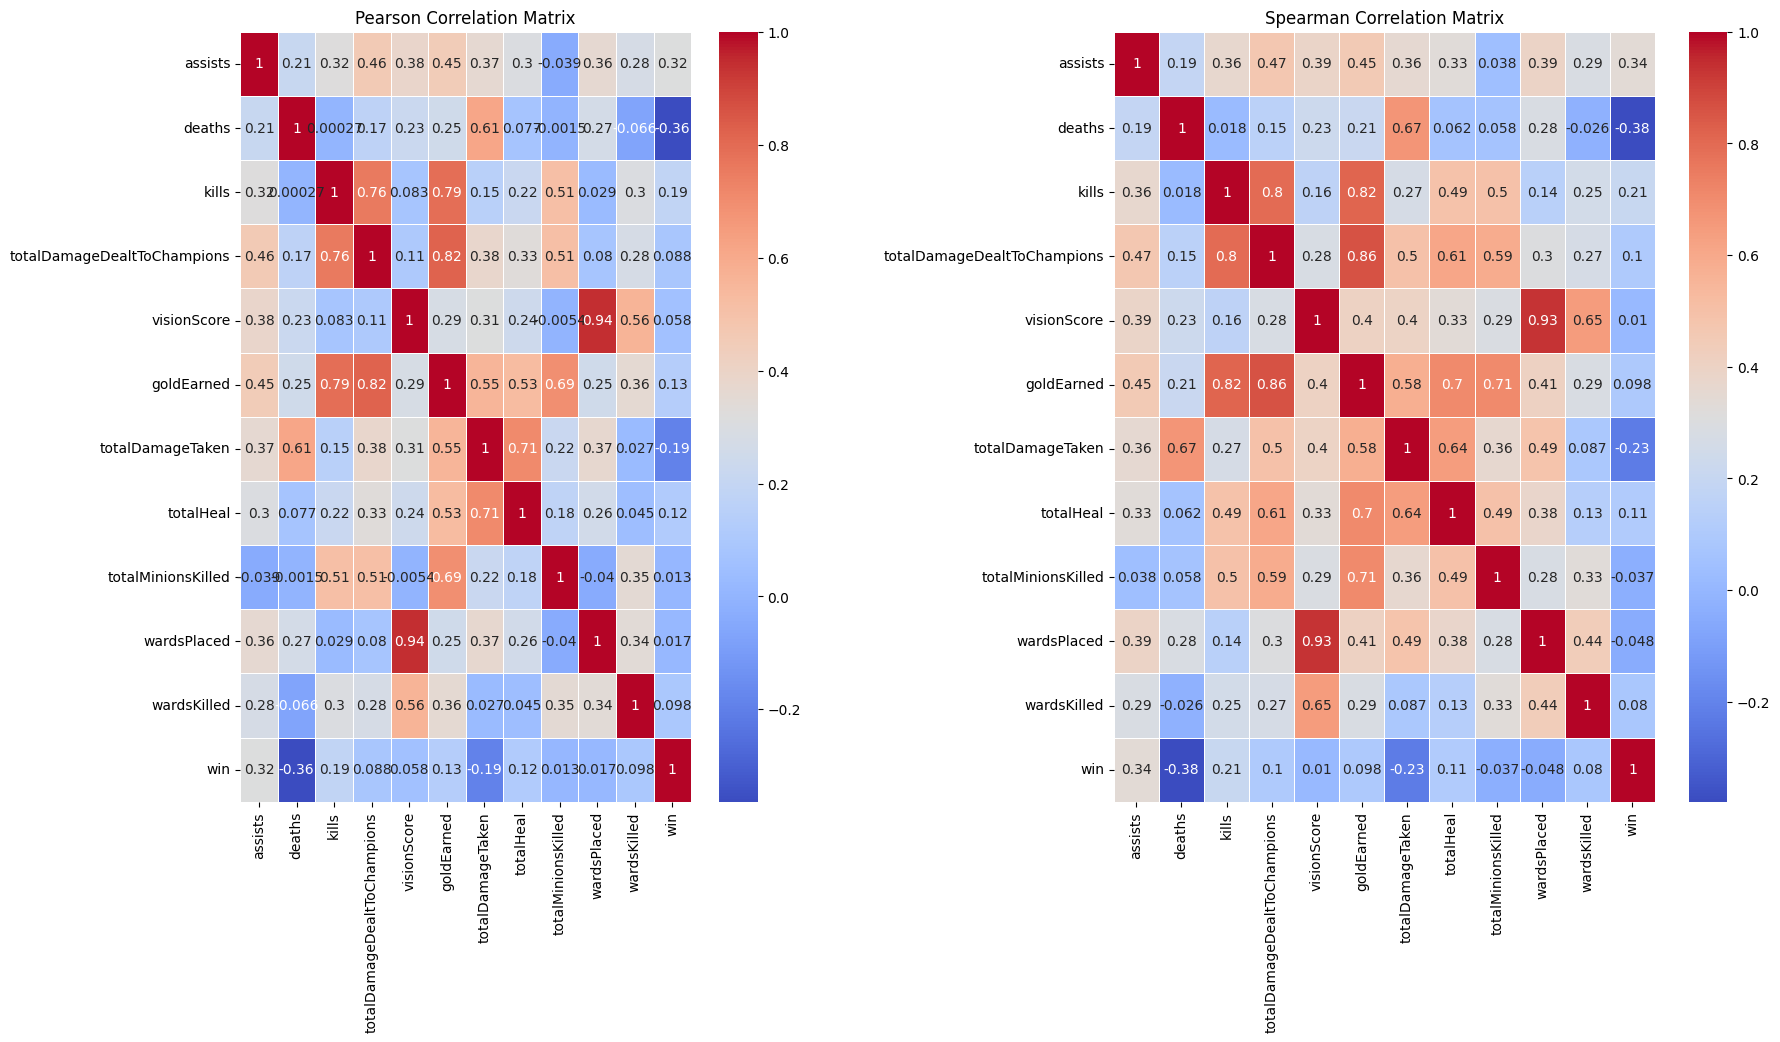

In [89]:
# Select relevant columns
columns_of_interest = ['assists', 'deaths', 'kills', 'totalDamageDealtToChampions', 'visionScore',
                         'goldEarned', 'totalDamageTaken', 'totalHeal', 'totalMinionsKilled',
                         'wardsPlaced', 'wardsKilled', 'win']

# Filter rows for your puuid
your_performance = participants_df[participants_df['puuid'] == your_puuid][columns_of_interest]

# Set 'win' column to 1 for win and 0 for loss (for plotting purposes)
your_performance['win'] = your_performance['win'].apply(lambda x: 1 if x else 0)

# Calculate the correlation matrices (Pearson and Spearman)
pearson_correlation_matrix = your_performance.corr(method='pearson')
spearman_correlation_matrix = your_performance.corr(method='spearman')

# Create subplots for both correlation matrices with larger size
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1.2]})

# Plot Pearson correlation matrix
sns.heatmap(pearson_correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')

# Add some space between the matrices
fig.subplots_adjust(wspace=0.5)

# Plot Spearman correlation matrix
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')

# Display the subplots
plt.show()


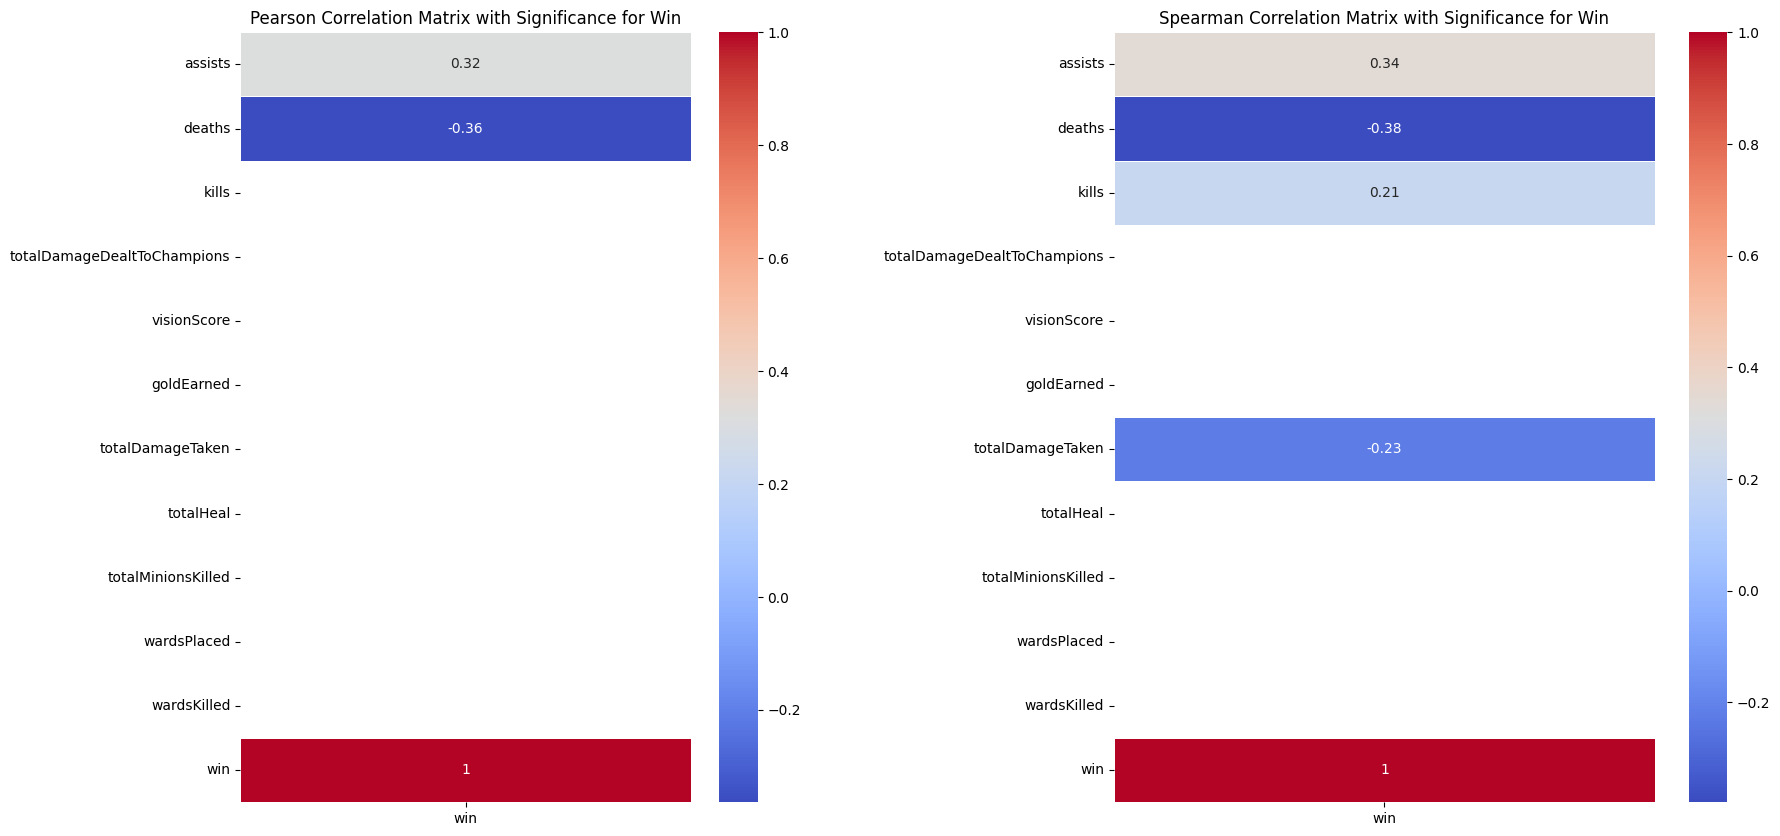

In [90]:
# Select relevant columns
columns_of_interest = ['assists', 'deaths', 'kills', 'totalDamageDealtToChampions', 'visionScore',
                         'goldEarned', 'totalDamageTaken', 'totalHeal', 'totalMinionsKilled',
                         'wardsPlaced', 'wardsKilled', 'win']

# Filter rows for your puuid
your_performance = participants_df[participants_df['puuid'] == your_puuid][columns_of_interest]

# Calculate the correlation matrices (Pearson and Spearman)
pearson_correlation_matrix = your_performance.corr(method='pearson')
spearman_correlation_matrix = your_performance.corr(method='spearman')

# Calculate p-values for Pearson correlation with 'win'
pearson_p_values = pd.DataFrame(index=pearson_correlation_matrix.index)
for i in pearson_correlation_matrix.index:
    pearson_p_values.loc[i, 'win'] = pearsonr(your_performance[i], your_performance['win'])[1]

# Calculate p-values for Spearman correlation with 'win'
spearman_p_values = pd.DataFrame(index=spearman_correlation_matrix.index)
for i in spearman_correlation_matrix.index:
    spearman_p_values.loc[i, 'win'] = spearmanr(your_performance[i], your_performance['win'])[1]

# Create subplots for both correlation matrices with larger size
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1.2]})

# Plot Pearson correlation matrix with significant correlations highlighted
sns.heatmap(pearson_correlation_matrix[['win']], annot=True, cmap='coolwarm', linewidths=.5, ax=axes[0],
            mask=(pearson_p_values > 0.05))  # Highlight non-significant correlations
axes[0].set_title('Pearson Correlation Matrix with Significance for Win')

# Add some space between the matrices
fig.subplots_adjust(wspace=0.5)

# Plot Spearman correlation matrix with significant correlations highlighted
sns.heatmap(spearman_correlation_matrix[['win']], annot=True, cmap='coolwarm', linewidths=.5, ax=axes[1],
            mask=(spearman_p_values > 0.05))  # Highlight non-significant correlations
axes[1].set_title('Spearman Correlation Matrix with Significance for Win')

# Display the subplots
plt.show()

In [91]:
# Select relevant columns
columns_of_interest = ['assists', 'deaths', 'kills', 'totalDamageDealtToChampions', 'visionScore',
                         'goldEarned', 'totalDamageTaken', 'totalHeal', 'totalMinionsKilled',
                         'wardsPlaced', 'wardsKilled', 'win']

# Filter rows for your puuid
your_performance = participants_df[participants_df['puuid'] == your_puuid][columns_of_interest]

# Create DataFrames to store correlation coefficients and p-values
pearson_results_df = pd.DataFrame(index=columns_of_interest[:-1], columns=['Pearson_Correlation', 'P_Value'])
spearman_results_df = pd.DataFrame(index=columns_of_interest[:-1], columns=['Spearman_Correlation', 'P_Value'])

# Iterate over columns and calculate Pearson and Spearman correlation coefficients and p-values
for column in columns_of_interest[:-1]:
    pearson_corr, pearson_p_value = pearsonr(your_performance[column], your_performance['win'])
    spearman_corr, spearman_p_value = spearmanr(your_performance[column], your_performance['win'])

    pearson_results_df.loc[column] = [pearson_corr, pearson_p_value]
    spearman_results_df.loc[column] = [spearman_corr, spearman_p_value]

# Set a significance level (alpha)
alpha = 0.05

# Display columns with significant correlations (p-value < alpha) for Pearson
significant_pearson_columns = pearson_results_df[pearson_results_df['P_Value'] < alpha]
print("Columns with significant Pearson correlations:")
print(significant_pearson_columns)

# Display columns with significant correlations (p-value < alpha) for Spearman
significant_spearman_columns = spearman_results_df[spearman_results_df['P_Value'] < alpha]
print("\nColumns with significant Spearman correlations:")
print(significant_spearman_columns)

Columns with significant Pearson correlations:
        Pearson_Correlation   P_Value
assists            0.318178  0.001255
deaths            -0.363633    0.0002

Columns with significant Spearman correlations:
                 Spearman_Correlation   P_Value
assists                      0.338991  0.000561
deaths                      -0.379037  0.000101
kills                        0.206089  0.039675
totalDamageTaken            -0.226262  0.023598


**2-** This code evaluates and visually represents the adjusted overall performance of ADC champions in League of Legends. To ensure fairness, the adjustment considers **differing match counts** per champion. By **assigning weights** to performance metrics and **normalizing each champion's overall performance based on the total matches played**, the resulting bar plot provides a balanced assessment. The inclusion of a red dashed line indicates the average adjusted overall performance, aiding in identifying champions that **outperform the average**, ensuring a fair comparison across different sample sizes.

<ipython-input-92-4c024b171e4b>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='adjustedOverallPerformance', y='championName', data=champion_stats, palette='viridis')


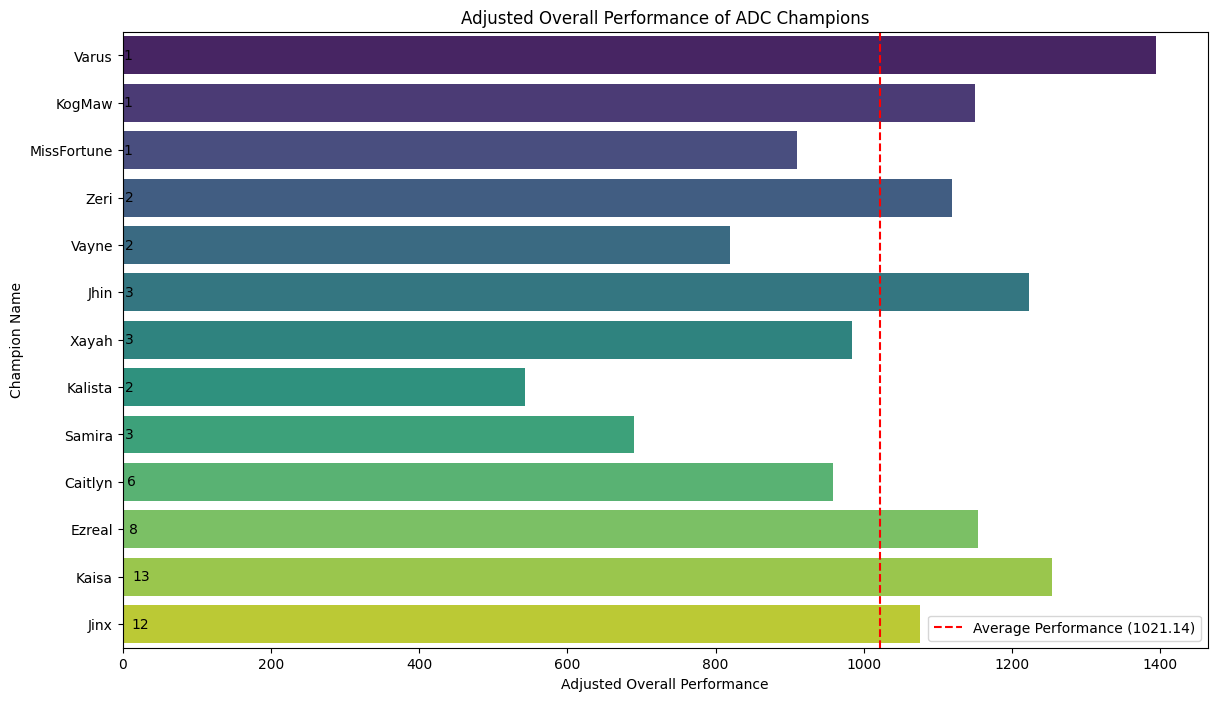

In [92]:
# Assuming 'participants_df' is your DataFrame
# Select relevant columns
columns_of_interest = ['championName', 'kills', 'deaths', 'assists', 'goldEarned', 'totalDamageDealtToChampions', 'win', 'role']

# Filter rows for your puuid and ADC role
your_adc_performance = participants_df[(participants_df['puuid'] == your_puuid) & (participants_df['role'] == 'CARRY')][columns_of_interest] ## ROLE CAN BE EDITED FOR DIFFERENT ANALYSIS

# Define weights for each metric based on their importance (you can adjust these)
weights = {
    'kills': 3,
    'deaths': -2,
    'assists': 2,
    'goldEarned': 1.5,
    'totalDamageDealtToChampions': 2,
    'win': 5  # Winning is crucial, so it has a higher weight
}

# Transform and normalize metrics
for metric, weight in weights.items():
    your_adc_performance[metric] = your_adc_performance[metric] * weight


# Group by championName and calculate weighted mean and count
champion_stats = your_adc_performance.groupby('championName').agg({
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean',
    'goldEarned': 'mean',
    'totalDamageDealtToChampions': 'mean',
    'win': 'mean'
}).reset_index()

# Count the number of matches played for each champion
champion_stats['matchesPlayed'] = your_adc_performance.groupby('championName')['championName'].count().values

# Calculate the overall performance score
champion_stats['overallPerformance'] = (champion_stats.drop(['championName', 'matchesPlayed', 'win'], axis=1).sum(axis=1)
                                        / champion_stats['matchesPlayed'])

# Sort the data by overallPerformance for better visualization
champion_stats = champion_stats.sort_values(by='overallPerformance', ascending=False)

# Calculate the adjusted overall performance
total_matches = champion_stats['matchesPlayed'].sum()
champion_stats['adjustedOverallPerformance'] = champion_stats.apply(
    lambda row: row['overallPerformance'] * row['matchesPlayed'] / total_matches, axis=1
)
# Calculate the average adjusted overall performance
average_performance = champion_stats['adjustedOverallPerformance'].mean()

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='adjustedOverallPerformance', y='championName', data=champion_stats, palette='viridis')
plt.axvline(x=average_performance, color='red', linestyle='--', label=f'Average Performance ({average_performance:.2f})')
plt.title('Adjusted Overall Performance of ADC Champions')
plt.xlabel('Adjusted Overall Performance')
plt.ylabel('Champion Name')
plt.legend()  # Show the legend with the average line

# Annotate each bar with the number of matches played
for index, value in enumerate(champion_stats['matchesPlayed']):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=10)

plt.show()


**3-** This code produces a bar plot using seaborn, highlighting the adjusted overall performance of ADC champions with 6 or more matches played. The inclusion of a **minimal match threshold ensures statistical significance.** Champions with adjusted overall performance above the average (indicated by a red dashed line) are considered potentially good picks, enhancing clarity and aiding in the assessment of ADC champion effectiveness. The annotations on each bar display the number of matches played, providing valuable context for the analysis.

<ipython-input-93-1f40f6a04f7b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='adjustedOverallPerformance', y='championName', data=filtered_champion_stats, palette='viridis')


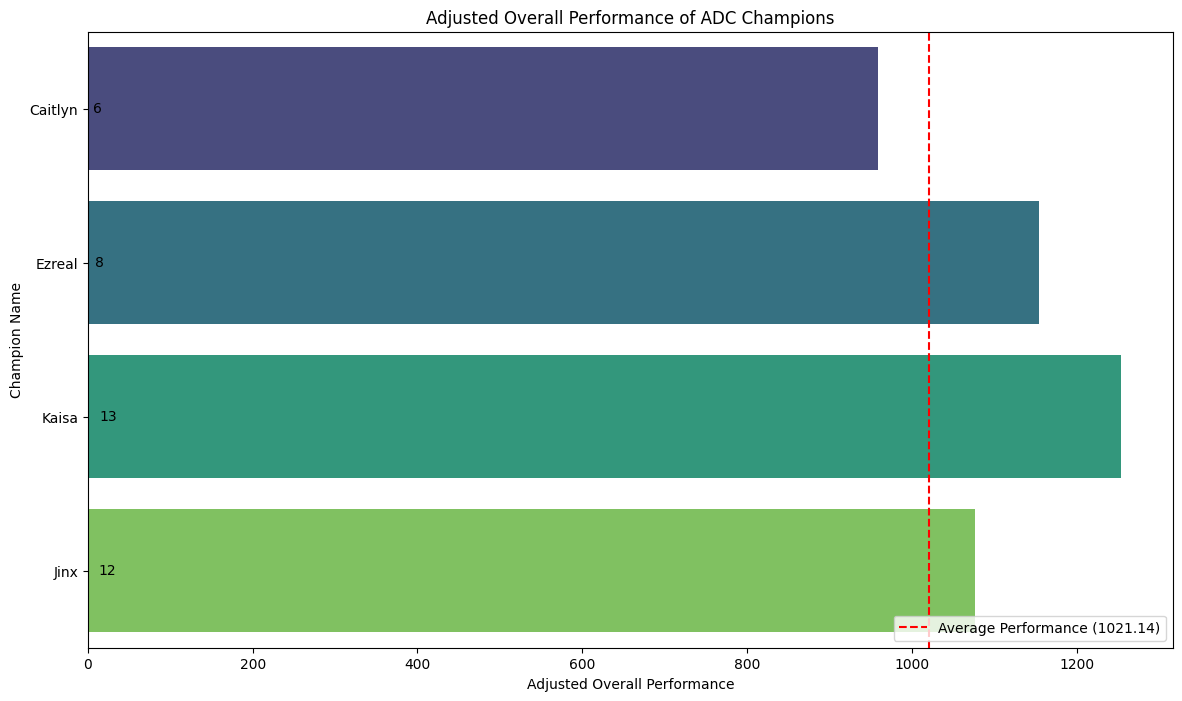

In [93]:
# Filter champions with 3 or more matches played
filtered_champion_stats = champion_stats[champion_stats['matchesPlayed'] >= 6]

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(x='adjustedOverallPerformance', y='championName', data=filtered_champion_stats, palette='viridis')
plt.axvline(x=average_performance, color='red', linestyle='--', label=f'Average Performance ({average_performance:.2f})')

# Annotate each bar with the number of matches played
for index, value in enumerate(filtered_champion_stats['matchesPlayed']):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=10)

# Set legend position to bottom right
plt.legend(loc='lower right')

plt.title('Adjusted Overall Performance of ADC Champions')
plt.xlabel('Adjusted Overall Performance')
plt.ylabel('Champion Name')
plt.show()


**4-**This code analyzes the relationship between effective vision contributions and match outcomes in League of Legends. The effective vision is computed by combining various vision-related metrics using assigned weights. To delve into the statistical significance of this relationship, a two-sample t-test was employed to compare the effective vision scores between matches won (True, 1) and matches lost (False, 0).

The resulting bar plot illustrates the distribution of these win and loss labels for the 'win' variable, showcasing the impact of effective vision on match results. The inclusion of the t-test enhances the analysis by providing insights into whether the observed differences in effective vision scores are statistically significant, contributing valuable information to strategic decision-making in gameplay.


<ipython-input-94-2ceef5fec955>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  your_data['effective_vision'] = (
<ipython-input-94-2ceef5fec955>:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='win', y='effective_vision', data=your_data, ci=None)


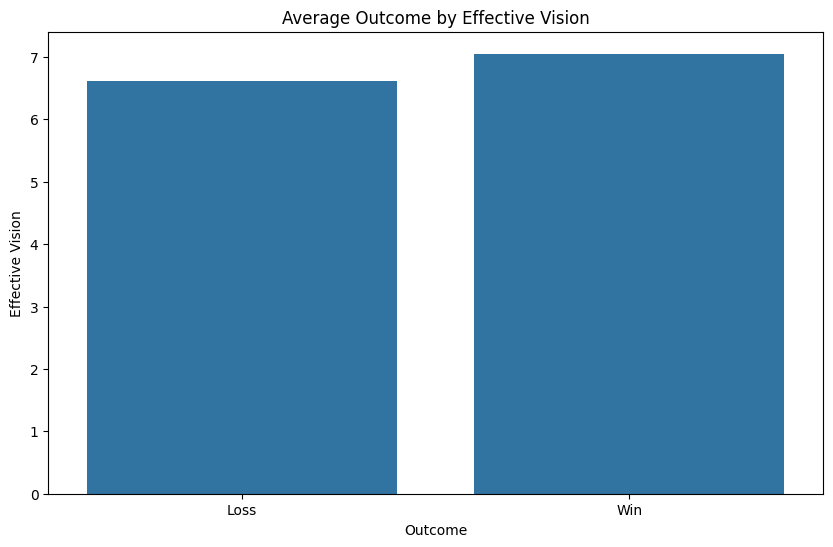

T-statistic: 0.5466648013676497
P-value: 0.5858907114297485
There is not enough evidence to claim a significant difference in effective vision.


In [94]:
# Assuming 'all_match_data' is your list of match data
# If 'all_match_data' is a list of dictionaries, you can create a DataFrame like this:
df = pd.DataFrame(all_match_data)

# Extract information from the 'participants' column
participants_df = json_normalize(df['info'], record_path='participants', meta=['gameId'])

# Filter data for your PUUID
your_data = participants_df[participants_df['puuid'] == your_puuid]

# Assign adjusted weights to each vision-related metric
weights = {
    'visionScore': 0.3,
    'wardsPlaced': 0.15,
    'wardsKilled': 0.15,
    'visionWardsBoughtInGame': 0.1,
    'detectorWardsPlaced': 0.2,  # Considering detector ward is essentially a vision ward
    'visionClearedPings': 0.05
}

# Calculate Effective Vision based on the adjusted interplay of metrics with weights
your_data['effective_vision'] = (
    weights['visionScore'] * your_data['visionScore'] +
    weights['wardsPlaced'] * your_data['wardsPlaced'] +
    weights['wardsKilled'] * your_data['wardsKilled'] +
    weights['visionWardsBoughtInGame'] * your_data['visionWardsBoughtInGame'] +
    weights['detectorWardsPlaced'] * your_data['detectorWardsPlaced'] +
    weights['visionClearedPings'] * your_data['visionClearedPings']
)

# Create a bar plot showing the average win rate for different levels of effective vision contribution
plt.figure(figsize=(10, 6))
sns.barplot(x='win', y='effective_vision', data=your_data, ci=None)

# Replace x-axis labels with more descriptive ones
plt.xticks(ticks=[0, 1], labels=['Loss', 'Win'])

plt.title('Average Outcome by Effective Vision')
plt.xlabel('Outcome')
plt.ylabel('Effective Vision')
plt.show()

# Assuming your_data has columns 'win' and 'effective_vision'
win_data = your_data[your_data['win'] == 1]['effective_vision']
loss_data = your_data[your_data['win'] == 0]['effective_vision']

# Perform independent t-test
t_stat, p_value = ttest_ind(win_data, loss_data, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in effective vision between wins and losses is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in effective vision.")


**5-** In this section, pivotal gaming metrics are meticulously selected and categorized to fuel the **Logistic Regression model**'s predictive prowess. The numeric features encompass critical indicators like **kills, deaths, assists, gold earned, and total damage dealt to champions**, offering quantitative insights into individual gameplay. Complementing these, the categorical feature **'Champion Name'** introduces a qualitative dimension, capturing the distinctive attributes associated with each champion. These features collectively lay the foundation for the model's training, contributing to its ability to discern nuanced patterns and **predict match outcomes**. Through this thoughtful selection, the model gains a holistic understanding of personal gaming performance, providing a comprehensive framework for outcome prediction in the realm of gaming analytics.

The logistic regression model is a statistical method used for predicting binary outcomes, making it suitable for applications like predicting whether a team wins or loses a gaming match. The model was trained and evaluated using a dataset that included these selected features.

To assess the significance of each feature in predicting match outcomes, the **model's coefficients were examined along with their associated p-values**. A p-value less than 0.05 was considered statistically significant, indicating a feature's influence on the prediction.

In [95]:
# Select relevant columns
columns_of_interest = ['championName', 'kills', 'deaths', 'assists', 'goldEarned', 'totalDamageDealtToChampions', 'win']

# Filter rows for your puuid
your_performance = participants_df[participants_df['puuid'] == your_puuid][columns_of_interest]

# Set 'win' column to 1 for win and 0 for loss
your_performance['win'] = your_performance['win'].apply(lambda x: 1 if x else 0)

# Split features and target variable
X = your_performance.drop('win', axis=1)
y = your_performance['win']

# Define numeric and categorical features
numeric_features = ['kills', 'deaths', 'assists', 'goldEarned', 'totalDamageDealtToChampions']
categorical_features = ['championName']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Initialize the logistic regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Adjust max_iter as needed
])

# Define hyperparameters for tuning
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create dummy columns for championName in both training and test datasets
X_train_encoded = pd.get_dummies(X_train, columns=['championName'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['championName'], drop_first=True)

# Ensure the columns in the test dataset match the order of the columns in the training dataset
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Initialize the logistic regression model with L1 regularization
logit_model = sm.Logit(y_train, sm.add_constant(X_train_encoded))
result = logit_model.fit_regularized(method='l1', alpha=0.1)  # You can adjust the alpha parameter

# Display the summary including p-values
print(result.summary())

Best Hyperparameters: {'classifier__C': 0.1}
Confusion Matrix:
[[6 4]
 [3 7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.64      0.70      0.67        10

    accuracy                           0.65        20
   macro avg       0.65      0.65      0.65        20
weighted avg       0.65      0.65      0.65        20



/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.33919463430862995
            Iterations: 154
            Function evaluations: 168
            Gradient evaluations: 154
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                   80
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                           21
Date:                Thu, 18 Jan 2024   Pseudo R-squ.:                  0.3149
Time:                        22:45:14   Log-Likelihood:                -37.972
converged:                       True   LL-Null:                       -55.427
Covariance Type:            nonrobust   LLR p-value:                   0.02888
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

<ipython-input-96-0c0d56affde1>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef, y=feature_names, palette=colors)


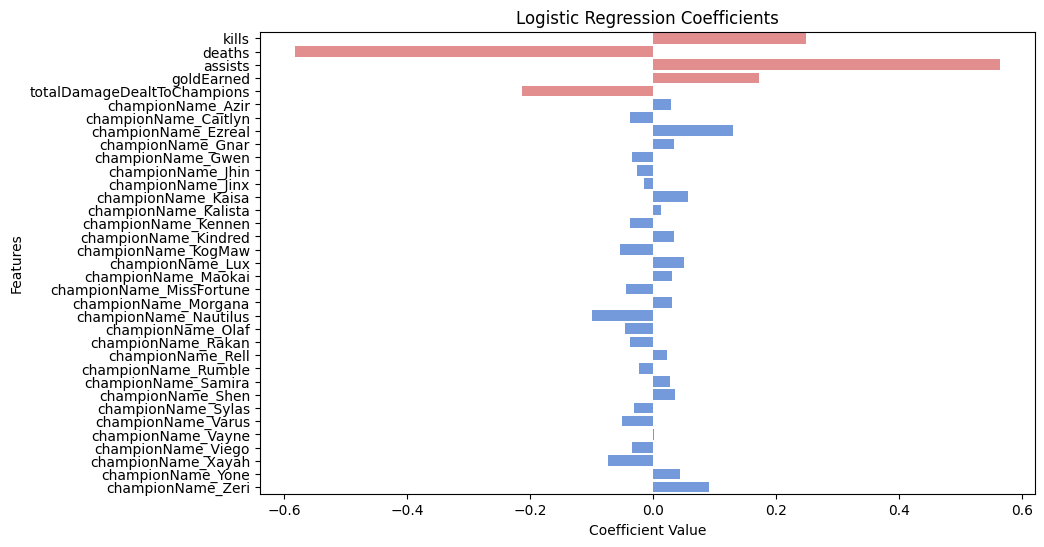

In [96]:
# Display coefficients as a bar plot with different colors for championName bars and others
plt.figure(figsize=(10, 6))

# Set colors for championName bars and others
champion_color = 'cornflowerblue'  # Choose your desired color for championName bars
other_color = 'lightcoral'  # Choose your desired color for other features

# Get feature names after one-hot encoding
feature_names = numeric_features + list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
coef = grid_search.best_estimator_.named_steps['classifier'].coef_[0]

# Create a list of colors based on the feature type
colors = [champion_color if 'championName' in feature else other_color for feature in feature_names]

# Plot the bar plot with specified colors
sns.barplot(x=coef, y=feature_names, palette=colors)

plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


In [97]:
# Initialize the logistic regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Increase max_iter for convergence
])

# Fit the model to the training data
model.fit(X_train, y_train)

# Use the best model for predictions
best_model = model.named_steps['classifier']

# Display coefficients with corresponding feature names and values
coef = best_model.coef_[0]
feature_names = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
print("\nNumerical values of Coefficients:")
print(coefficients_df)



Numerical values of Coefficients:
                        Feature  Coefficient
0                         kills     0.525824
1                        deaths    -1.125113
2                       assists     1.151109
3                    goldEarned     0.698496
4   totalDamageDealtToChampions    -1.108804
5             championName_Azir     0.443223
6          championName_Caitlyn    -0.117634
7           championName_Ezreal     0.722420
8             championName_Gnar     0.261904
9             championName_Gwen    -0.217357
10            championName_Jhin    -0.284341
11            championName_Jinx    -0.057798
12           championName_Kaisa     0.126754
13         championName_Kalista     0.076644
14          championName_Kennen    -0.178772
15         championName_Kindred     0.125453
16          championName_KogMaw    -0.441497
17             championName_Lux     0.535275
18          championName_Maokai     0.114894
19     championName_MissFortune    -0.320677
20         championN

# **Benchmarking Performance: Contrasting Personal Metrics with Enemy Team**

*In this segment, we embark on a comparative journey, benchmarking personal gameplay metrics against those of the enemy team. By contrasting key performance indicators, such as vision score, gold earned, and overall effectiveness, we uncover patterns and disparities. This comparative analysis provides a strategic edge, allowing us to discern individual strengths and weaknesses in comparison to adversaries.*

**1-** In the benchmarking analysis, several key performance metrics were examined to evaluate the player's ADC against the enemy ADC. The metrics encompassed diverse aspects, including **KDA ratio, total damage dealt to champions, gold earned, assists, deaths, kills, total minions killed, and effective vision score**. Each comparison plot provides a visual representation of the average values for these metrics, contrasting the player's ADC with the enemy ADC.

To assess the statistical significance of these differences, independent two-sample t-tests were conducted for each metric. The **t-tests** evaluated whether the observed differences in performance metrics between the player's ADC and the enemy ADC were **statistically significant**. The results of these tests are crucial in understanding whether the disparities observed in the benchmarks are likely due to chance or if they reflect meaningful distinctions in performance.

These benchmarks, coupled with the outcomes of the t-tests, offer valuable insights into the player's relative performance in critical aspects of the game. The inclusion of statistical significance helps in strategic decision-making by highlighting areas where the player's ADC significantly outperforms or lags behind the enemy ADC, aiding in targeted improvements and informed gameplay adjustments.


In [98]:
# Assuming 'all_match_data' is your list of match data
# If 'all_match_data' is a list of dictionaries, you can create a DataFrame like this:
df = pd.DataFrame(all_match_data)

# Extract information from the 'participants' column
participants_df = pd.json_normalize(df['info'], record_path='participants', meta=['gameId'])

# Filter data for your PUUID using 'puuid' column
your_data = participants_df[participants_df['puuid'] == your_puuid]

# Filter matches where you played as ADC
adc_matches = your_data[(your_data['lane'] == 'BOTTOM') & (your_data['role'] == 'CARRY')]

# Extract relevant columns for analysis
relevant_columns = ['kills', 'deaths', 'assists', 'goldEarned', 'totalMinionsKilled', 'totalDamageDealtToChampions',
                     'visionScore', 'wardsPlaced', 'wardsKilled', 'win']

your_stats = adc_matches[relevant_columns]

# Calculate additional metrics for you
your_stats['kdaRatio'] = (your_stats['kills'] + your_stats['assists']) / your_stats['deaths']

# Extract information for the enemy ADC in the same matches
enemy_adc_stats = participants_df[
    (participants_df['gameId'].isin(adc_matches['gameId'])) &
    (participants_df['lane'] == 'BOTTOM') &
    (participants_df['role'] == 'CARRY') &
    (participants_df['puuid'] != your_puuid)
][relevant_columns]

# Calculate additional metrics for the enemy ADC
enemy_adc_stats['kdaRatio'] = (enemy_adc_stats['kills'] + enemy_adc_stats['assists']) / enemy_adc_stats['deaths']

# Plotting
metrics_to_plot = ['kills', 'deaths', 'assists', 'goldEarned', 'totalMinionsKilled', 'totalDamageDealtToChampions',
                   'visionScore', 'wardsPlaced', 'wardsKilled', 'kdaRatio']

# Extract relevant performance metrics for your ADC matches
your_adc_performance = adc_matches[['kills', 'deaths', 'assists', 'goldEarned', 'visionScore', 'wardsPlaced', 'wardsKilled']]

# Define weights for each metric
vision_weight = 2  # Adjust the weight based on your preference
wards_placed_weight = 1
wards_killed_weight = 1

# Calculate effective vision for your ADC with weights
your_adc_performance['effectiveVision'] = (
    vision_weight * your_adc_performance['visionScore'] +
    wards_placed_weight * your_adc_performance['wardsPlaced'] +
    wards_killed_weight * your_adc_performance['wardsKilled']
)

# Extract information for the enemy ADC in the same matches
enemy_adc_performance = participants_df[
    (participants_df['gameId'].isin(adc_matches['gameId'])) &
    (participants_df['lane'] == 'BOTTOM') &
    (participants_df['role'] == 'CARRY') &
    (participants_df['puuid'] != your_puuid)
][['kills', 'deaths', 'assists', 'goldEarned', 'visionScore', 'wardsPlaced', 'wardsKilled']]

# Calculate effective vision for the enemy ADC with weights
enemy_adc_performance['effectiveVision'] = (
    vision_weight * enemy_adc_performance['visionScore'] +
    wards_placed_weight * enemy_adc_performance['wardsPlaced'] +
    wards_killed_weight * enemy_adc_performance['wardsKilled']
)

<ipython-input-98-9c1f95f99a88>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  your_stats['kdaRatio'] = (your_stats['kills'] + your_stats['assists']) / your_stats['deaths']
<ipython-input-98-9c1f95f99a88>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  your_adc_performance['effectiveVision'] = (


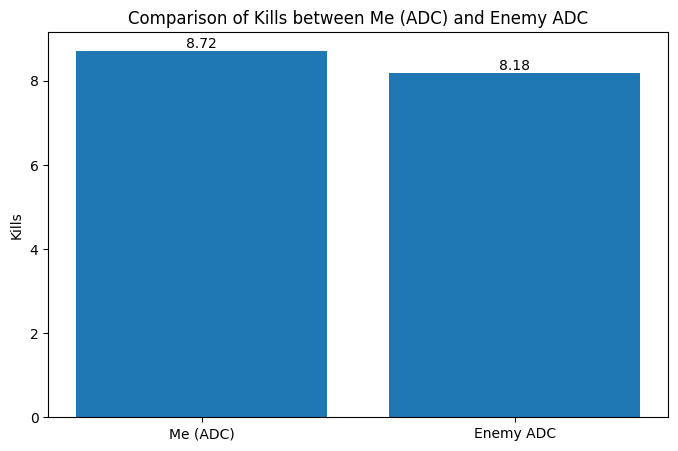

T-statistic: 0.5352532917807692
P-value: 0.5937376701891197
There is not enough evidence to claim a significant difference in kills.


In [99]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['kills'].mean(), enemy_adc_stats['kills'].mean()])
plt.title('Comparison of Kills between Me (ADC) and Enemy ADC')
plt.ylabel('Kills')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'kills'
my_kills = your_stats['kills']
enemy_kills = enemy_adc_stats['kills']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_kills, enemy_kills, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in kills between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in kills.")


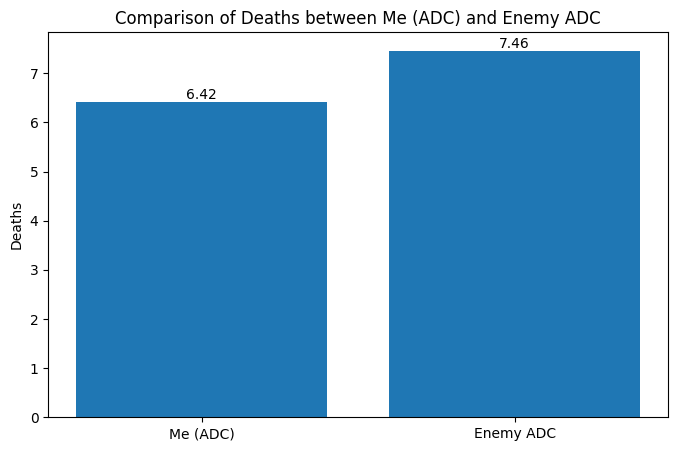

T-statistic: -1.8205682551240985
P-value: 0.07152189291643743
There is not enough evidence to claim a significant difference in deaths.


In [100]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['deaths'].mean(), enemy_adc_stats['deaths'].mean()])
plt.title('Comparison of Deaths between Me (ADC) and Enemy ADC')
plt.ylabel('Deaths')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'deaths'
my_deaths = your_stats['deaths']
enemy_deaths = enemy_adc_stats['deaths']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_deaths, enemy_deaths, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in deaths between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in deaths.")



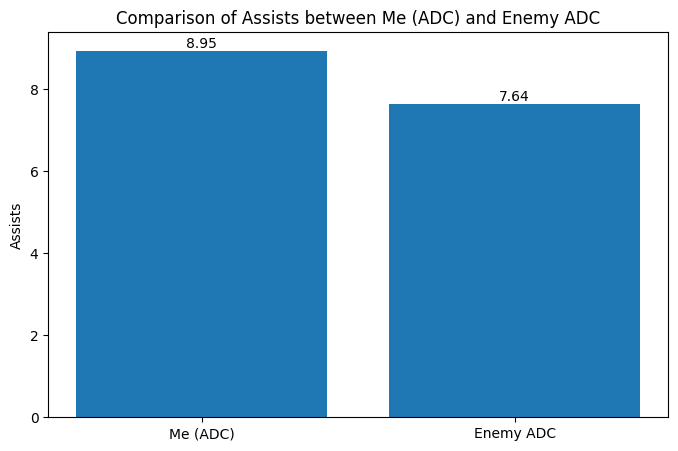

T-statistic: 1.6549734792413318
P-value: 0.10106428095903731
There is not enough evidence to claim a significant difference in assists.


In [101]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['assists'].mean(), enemy_adc_stats['assists'].mean()])
plt.title('Comparison of Assists between Me (ADC) and Enemy ADC')
plt.ylabel('Assists')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'assists'
my_assists = your_stats['assists']
enemy_assists = enemy_adc_stats['assists']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_assists, enemy_assists, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in assists between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in assists.")


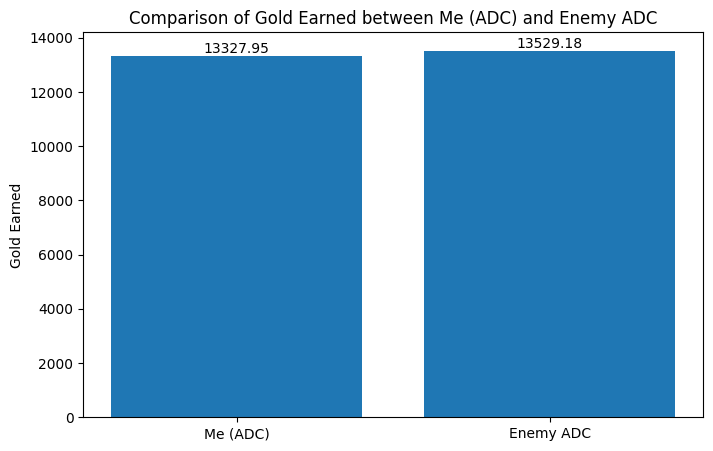

T-statistic: -0.3082020173723094
P-value: 0.7585685190697805
There is not enough evidence to claim a significant difference in gold earned.


In [102]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['goldEarned'].mean(), enemy_adc_stats['goldEarned'].mean()])
plt.title('Comparison of Gold Earned between Me (ADC) and Enemy ADC')
plt.ylabel('Gold Earned')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'goldEarned'
my_gold_earned = your_stats['goldEarned']
enemy_gold_earned = enemy_adc_stats['goldEarned']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_gold_earned, enemy_gold_earned, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in gold earned between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in gold earned.")


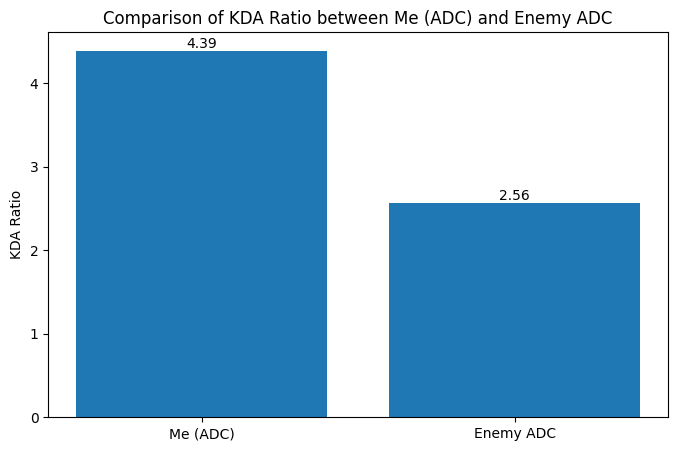

T-statistic: 2.50053695032745
P-value: 0.014539186167283079
The difference in KDA ratio between Me (ADC) and Enemy ADC is statistically significant.


In [103]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['kdaRatio'].mean(), enemy_adc_stats['kdaRatio'].mean()])
plt.title('Comparison of KDA Ratio between Me (ADC) and Enemy ADC')
plt.ylabel('KDA Ratio')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'kdaRatio'
my_kda_ratio = your_stats['kdaRatio']
enemy_kda_ratio = enemy_adc_stats['kdaRatio']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_kda_ratio, enemy_kda_ratio, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in KDA ratio between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in KDA ratio.")


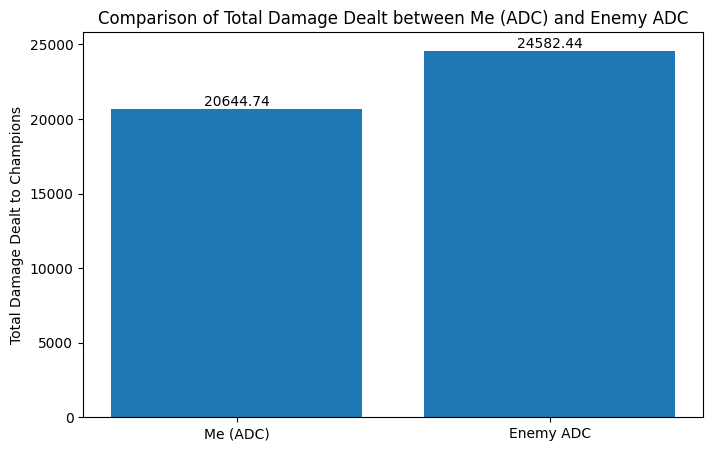

T-statistic: -1.8399132640329507
P-value: 0.06915673028165299
There is not enough evidence to claim a significant difference in Total Damage Dealt to Champions.


In [104]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['totalDamageDealtToChampions'].mean(), enemy_adc_stats['totalDamageDealtToChampions'].mean()])
plt.title('Comparison of Total Damage Dealt between Me (ADC) and Enemy ADC')
plt.ylabel('Total Damage Dealt to Champions')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'totalDamageDealtToChampions'
my_damage_dealt = your_stats['totalDamageDealtToChampions']
enemy_damage_dealt = enemy_adc_stats['totalDamageDealtToChampions']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_damage_dealt, enemy_damage_dealt, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in Total Damage Dealt to Champions between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in Total Damage Dealt to Champions.")



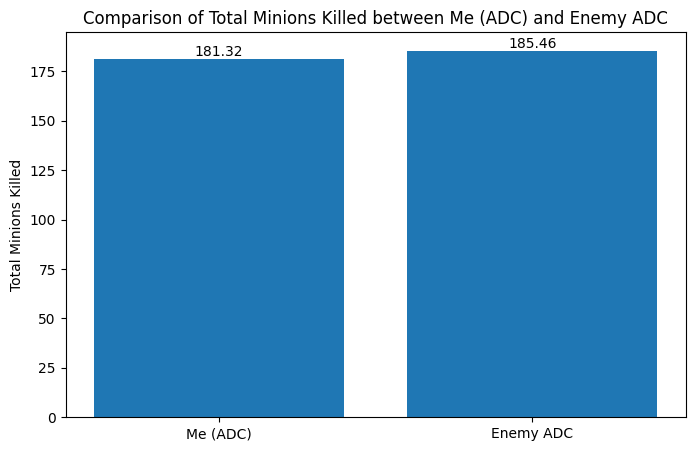

T-statistic: -0.47201084744486876
P-value: 0.638003438994109
There is not enough evidence to claim a significant difference in Total Minions Killed.


In [105]:
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_stats['totalMinionsKilled'].mean(), enemy_adc_stats['totalMinionsKilled'].mean()])
plt.title('Comparison of Total Minions Killed between Me (ADC) and Enemy ADC')
plt.ylabel('Total Minions Killed')

# Add numeric labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Assuming your_stats and enemy_adc_stats have columns 'totalMinionsKilled'
my_minions_killed = your_stats['totalMinionsKilled']
enemy_minions_killed = enemy_adc_stats['totalMinionsKilled']

# Perform independent t-test
t_stat, p_value = ttest_ind(my_minions_killed, enemy_minions_killed, equal_var=False)

# Check the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:  # You can choose your significance level
    print("The difference in Total Minions Killed between Me (ADC) and Enemy ADC is statistically significant.")
else:
    print("There is not enough evidence to claim a significant difference in Total Minions Killed.")


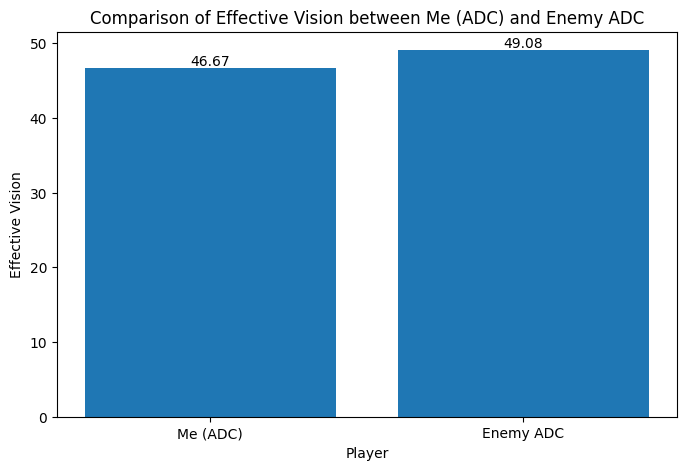

T-Statistic: -0.6139294641604567
P-Value: 0.5405897891415004
There is no significant difference in effective vision between Me (ADC) and Enemy ADC.


In [106]:
# Plotting comparison of effective vision
plt.figure(figsize=(8, 5))
bars = plt.bar(['Me (ADC)', 'Enemy ADC'], [your_adc_performance['effectiveVision'].mean(), enemy_adc_performance['effectiveVision'].mean()])
plt.title('Comparison of Effective Vision between Me (ADC) and Enemy ADC')
plt.xlabel('Player')
plt.ylabel('Effective Vision')

# Add numeric values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

# Extract the effective vision data for both groups
me_adc_effective_vision = your_adc_performance['effectiveVision']
enemy_adc_effective_vision = enemy_adc_performance['effectiveVision']

# Perform an independent two-sample t-test
t_statistic, p_value = ttest_ind(me_adc_effective_vision, enemy_adc_effective_vision)

# Display the results
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

# Interpret the results
if p_value < 0.05:
    print('The difference in effective vision between Me (ADC) and Enemy ADC is statistically significant.')
else:
    print('There is no significant difference in effective vision between Me (ADC) and Enemy ADC.')
